# Neural Network Model for Human Activity Recognition

by Jack Goon

In this notebook, I will walk through my several attempts at creating a neural network model trained by the [WISDM dataset](https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+). Here are the main sections:

    A. sklearn's MLPClassifier 
    B. keras, early editions 
    C. keras, final edition - includes preprocessing, grid search, training, and evaluation

## A. sklearn's MLPClassifier
### 1. Read data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

class Reader:
    def __init__(self, path, mode='f'):
        
        self.df = self.wrapper(path,mode)
    
    # read arff file
    def readarff(self, filename,collect=True): #collect if you need to collect attribute names
        with open(filename) as f:
            content = f.read().splitlines()
        data = False
        metalist = [] # storets metadata as list of rows
        datalist = [] # store data as list of rows
        
        # read data line-by-line
        for line in content:
            if data == True:
                line = line.split(",")
                datalist.append(line)
            elif line == "@data":
                data = True # read lines before "@data" as metadata and after as data
            else:
              # clean up metadata header
              if collect:
                line = line.replace(' "', ".")
                line = line.replace('" ', ".")
                line = line.replace(" ","")
                line = line.split(".")
                if len(line)==3: #ignore first two lines of file
                    line = line[1:3] #remove repetitive "@attribute"
                    metalist.append(line)
        
        # create dataframes from lists of rows
        if not collect:
            dataframe = pd.DataFrame(datalist,dtype=float)
            return dataframe
        else:
            dataframe = pd.DataFrame(datalist,dtype=float)
            metaframe = pd.DataFrame(metalist,columns=["attribute","description"])
            attributes = metaframe["attribute"].rename("SAMPLE")
            return dataframe, attributes
    
    def readdirectory(self, path,quiet=False): # make sure path ends in a slash
        alldata = []
        count = 0
        for filename in os.listdir(path):
            if filename.endswith(".arff"):
                if count == 0: #only collect attributes once
                    if not quiet:
                          print("processing "+filename+"; collecting attribute names")
                    dataframe, attributes = self.readarff(path+filename)
                    alldata.append(dataframe)
                else:
                    if not quiet:
                        print("processing "+filename)
                    dataframe = self.readarff(path+filename,collect=False)
                    alldata.append(dataframe)
                count += 1
                continue
            else:
                continue
        if not quiet:
            print("Concatenating data")
        alldata = pd.concat(alldata).reset_index(drop=True) #reset indices so it is continuous
        alldata.columns = attributes #assign column names
        return alldata
    
    def wrapper(self, path, mode='f'):
        if mode == 'f':
            try:
                df =  self.readarff(path, collect = True)
                return df
            except:
                print("make sure you inputted the correct arff FILE path")
        elif mode == 'd':
            try:
                df =  self.readdirectory(path, quiet=True)
                return df
            except:
                print("make sure you inputted the correct arff DIRECTORY path, ending with a slash")
        else:
            print("mode must either be 'f' or 'd'")
            return 0

In [2]:
phone_accel = Reader("../phone_accel/",mode='d').df
phone_accel

SAMPLE,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
0,A,0.060,0.110,0.215,0.255,0.240,0.070,0.030,0.010,0.005,...,0.550898,0.543819,0.751094,-0.005809,-0.376951,0.383184,0.377359,-0.103380,10.74990,1610.0
1,A,0.050,0.130,0.170,0.220,0.285,0.090,0.020,0.020,0.010,...,0.545153,0.538148,0.741898,0.069865,-0.368142,0.361264,0.488030,-0.070615,10.86330,1610.0
2,A,0.070,0.135,0.165,0.250,0.190,0.130,0.025,0.015,0.010,...,0.580717,0.573254,0.689070,0.227904,-0.299957,0.255459,0.568801,-0.134642,10.97220,1610.0
3,A,0.075,0.145,0.140,0.205,0.275,0.105,0.010,0.025,0.020,...,0.578014,0.570586,0.686601,0.244267,-0.280844,0.259784,0.567380,-0.128378,10.98140,1610.0
4,A,0.085,0.145,0.145,0.175,0.285,0.100,0.030,0.020,0.005,...,0.568111,0.560811,0.700471,0.057924,-0.399338,0.311718,0.398679,-0.245695,10.87960,1610.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23069,S,0.085,0.870,0.045,0.000,0.000,0.000,0.000,0.000,0.000,...,0.301115,0.297245,0.819750,0.843326,0.885157,-0.240015,0.404147,-0.194501,9.86525,1623.0
23070,S,0.045,0.930,0.025,0.000,0.000,0.000,0.000,0.000,0.000,...,0.250726,0.247505,0.882858,0.843529,0.924976,-0.375267,0.105853,-0.347694,9.83254,1623.0
23071,S,0.115,0.850,0.035,0.000,0.000,0.000,0.000,0.000,0.000,...,0.314565,0.310523,0.846374,0.783956,0.816690,-0.096962,0.283083,-0.055892,9.85928,1623.0
23072,S,0.085,0.850,0.060,0.005,0.000,0.000,0.000,0.000,0.000,...,0.353186,0.348647,0.739531,0.765779,0.813776,0.034647,0.414515,-0.073013,9.88992,1623.0


### 2. Preprocess data

In [3]:
# FORMAT DATA
# remove ACTIVITY, RESULTANT, MFCC values, COS values, and CORRELATION values (same as publication)
X = phone_accel[['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1',
       'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG',
       'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
       'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR', 'YVAR', 'ZVAR', 'RESULTANT']]
columns = X.columns
# FORMAT LABELS
# TODO, group similar activities
conversions = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 
               'J':9, 'K':10, 'L':11, 'M':12, 'O':13, 'P':14, 'Q':15, 'R':16, 'S':17}
y_raw = phone_accel['ACTIVITY']
y = []
# convert letters to 1's and 0's in a matrix
for i in y_raw:
    j = conversions[i] # convert activity letter to a number, j
    row = [0]*18 # initialize an array of zeros
    row[j]=1 # set the j'th item in the row to 1, indicating that the sample belongs to the j'th category
    y.append(row)
y = pd.DataFrame(y)
y.columns = conversions.keys()
print("Class labels:")
y.head()

Class labels:


,A,B,C,D,E,F,G,H,I,J,K,L,M,O,P,Q,R,S
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = columns
print("Attribute values:")
X.head()

Attribute values:


SAMPLE,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,XABSOLDEV,YABSOLDEV,ZABSOLDEV,XSTANDDEV,YSTANDDEV,ZSTANDDEV,XVAR,YVAR,ZVAR,RESULTANT
0,0.060,0.110,0.215,0.255,0.240,0.070,0.030,0.033898,0.029412,0.014925,...,0.193351,0.181758,0.191292,0.201925,0.179769,0.242555,0.438980,0.414337,0.479647,0.117847
1,0.050,0.130,0.170,0.220,0.285,0.090,0.020,0.067797,0.058824,0.014925,...,0.207436,0.177501,0.194296,0.211756,0.175840,0.247004,0.449987,0.409602,0.484254,0.125911
2,0.070,0.135,0.165,0.250,0.190,0.130,0.025,0.050847,0.058824,0.029851,...,0.224824,0.183938,0.210485,0.228667,0.182259,0.290345,0.468341,0.417311,0.527131,0.133655
3,0.075,0.145,0.140,0.205,0.275,0.105,0.010,0.084746,0.117647,0.000000,...,0.231089,0.184034,0.204281,0.231104,0.184393,0.290078,0.470930,0.419843,0.526878,0.134309
4,0.085,0.145,0.145,0.175,0.285,0.100,0.030,0.067797,0.029412,0.029851,...,0.231962,0.174996,0.182487,0.229676,0.177651,0.247354,0.469416,0.411791,0.484616,0.127070


### 3. Train model with neural network
Using [Scikit-learn's MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# shuffle and split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=1)

# define classifier to use stochastic gradient descent, sigmod activation function, regularization constant 1e-5, etc
clf = MLPClassifier(solver='sgd', activation='relu', alpha=1e-3, learning_rate_init = 0.01, 
                    hidden_layer_sizes=(100,100,100,25), random_state=1, max_iter = 1000) # 4000 for best performance
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100, 25), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### 4. Evaluate model performance

In [6]:
print("Training score:",clf.score(X_train, y_train))
print("Testing score:",clf.score(X_test, y_test))

Training score: 0.8608135719150517
Testing score: 0.7330637007077856


In [7]:
sample = X.iloc[30]
sample = np.array(sample).reshape(1, -1) #reshape because single sample
print("sample probability vector: ",clf.predict_proba(sample))
print("sample prediction vector: ",clf.predict(sample))
print("actual sample class vector: ",np.array(y.iloc[30]).reshape(1,-1))

sample probability vector:  [[9.10342386e-11 9.99998462e-01 5.24424937e-13 2.86037118e-14
  2.88201348e-23 2.74175881e-56 4.03009118e-21 3.56303212e-15
  2.02744115e-18 5.11418021e-22 6.11733734e-42 1.48190114e-19
  5.68719841e-18 5.51574026e-07 1.86167821e-21 2.94137240e-39
  8.48467772e-31 5.16143238e-37]]
sample prediction vector:  [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
actual sample class vector:  [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


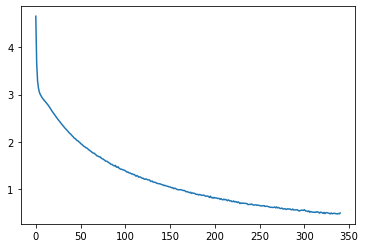

In [8]:
import matplotlib.pyplot as plt
loss_values = clf.loss_curve_
plt.plot(loss_values)
plt.show()

## B. Keras, early edition

### 1. Read data

In [9]:
from sklearn.preprocessing import LabelEncoder

phone_accel = Reader("../phone_accel/",mode='d').df

# read attributes
X = phone_accel[['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1',
       'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG',
       'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
       'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR', 'YVAR', 'ZVAR', 'RESULTANT']]
X = np.array(X)

# read and convert class labels to binary form
Y = phone_accel['ACTIVITY']
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
Y = pd.get_dummies(Y) # convert to one hot encoded Y

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify=Y, random_state=1)

### 2. Create Keras model

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.optimizers import SGD
from keras.optimizers import Adam

Below, the "layer call" action `x = dense(inputs)` is like drawing an arrow from "inputs" to this dense layer you created. You're "passing" the inputs to the dense layer, and you get x as the output.

In [11]:
p_input = 0
p_hidden = 0.1 # fraction of the inputs to drop
eta = 0.00001 # learning rate, not in use
m = 0.95 # momentum constant, not in use

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu')) # input layer
    model.add(Dropout(p_input)) # dropout applied to input layer
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(p_hidden)) # dropout applied to first hidden layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(p_hidden)) # dropout applied to second hidden layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(p_hidden)) # dropout regularization layer
    #model.add(Dense(32, activation='relu', kernel_regularizer='l2')) # default regularization constant 0.01
    model.add(Dense(Y.shape[1], activation = 'softmax')) # output layer = softmax for probabilities
    # Compile model
    
    sgd = SGD(lr=eta, momentum=m)
    adam = Adam()
    
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

# from https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    epochs = range(1,len(history.history[loss_list[0]]) + 1) # x values on graph
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### 3. Train and evaluate model

#### First, test model on entire test set and try different batch sizes

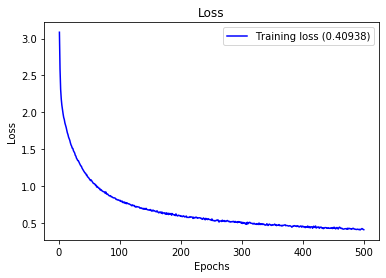

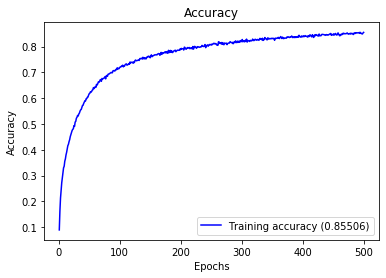

Test score: 0.8177090883255005


In [12]:
import time
start_time = time.time()
estimator = KerasClassifier(build_fn=baseline_model, epochs=500, batch_size=200, verbose=0)
kfold = KFold(n_splits=4, shuffle=True)

# uncomment this for cross validation
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# print("%s seconds" % (time.time() - start_time))

history = estimator.fit(X_train, Y_train, verbose = 0)
plot_history(history)
print("Test score: "+str(estimator.score(X_test, Y_test)))

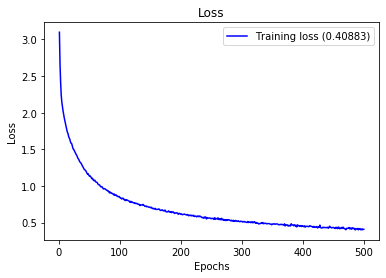

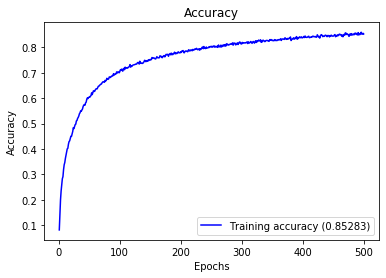

Test score: 0.8204535841941833


In [13]:
import time
start_time = time.time()
estimator = KerasClassifier(build_fn=baseline_model, epochs=500, batch_size=400, verbose=0)

# uncomment this for cross validation
# kfold = KFold(n_splits=4, shuffle=True)
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# print("%s seconds" % (time.time() - start_time))

history = estimator.fit(X_train, Y_train, verbose = 0)
plot_history(history)
print("Test score: "+str(estimator.score(X_test, Y_test)))

#### Now, let's use the model to evaluate accuracies for each individual class

In [14]:
classes = {"A":"Walking","B":"Jogging","C":"Stairs","D":"Sitting",
           "E":"Standing","F":"Typing","G":"Brushing teeth","H":"Eating soup",
           "I":"Eating chips","J":"Eating pasta","K":"Drinking from a cup",
           "L":"Eating sandwich","M":"Kicking (soccer ball)","O":"Playing catch (with tennis ball)",
           "P":"Dribbling (basketball)", "Q":"Writing","R":"Clapping","S":"Folding clothes"}

print("Model prediction accuracies based on phone acceleration data:")
print("="*61)
for i in encoder.classes_: # iterate through classes
    j = encoder.transform([i])
    idx = Y_test[j[0]] # create reference array to only choose samples from the i'th (aka j'th) class
    Y1 = Y_test[idx==1]
    X1 = X_test[idx==1]
    print(classes[i], "test score:","-"*(40-len(classes[i])),str(estimator.score(X1, Y1)))

Model prediction accuracies based on phone acceleration data:
Walking test score: --------------------------------- 0.9238845109939575
Jogging test score: --------------------------------- 0.9390863180160522
Stairs test score: ---------------------------------- 0.8926553726196289
Sitting test score: --------------------------------- 0.7968337535858154
Standing test score: -------------------------------- 0.8519480228424072
Typing test score: ---------------------------------- 0.8615819215774536
Brushing teeth test score: -------------------------- 0.8155844211578369
Eating soup test score: ----------------------------- 0.7207446694374084
Eating chips test score: ---------------------------- 0.7115902900695801
Eating pasta test score: ---------------------------- 0.7457627058029175
Drinking from a cup test score: --------------------- 0.694656491279602
Eating sandwich test score: ------------------------- 0.7989276051521301
Kicking (soccer ball) test score: ------------------- 0.8818181

## C. Keras, final edition

### 1. Preprocess data
To preprocess data, we will use four python functions/classes defined in the auxillary `wisdm_preprocess.py` file.

In [1]:
from wisdm_preprocess import Reader, preprocess, findOutliers, heatmap

In [2]:
# Read data with Reader class
df = Reader("../phone_accel/",mode='d').df # phone accel data
df

SAMPLE,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
0,A,0.060,0.110,0.215,0.255,0.240,0.070,0.030,0.010,0.005,...,0.550898,0.543819,0.751094,-0.005809,-0.376951,0.383184,0.377359,-0.103380,10.74990,1610.0
1,A,0.050,0.130,0.170,0.220,0.285,0.090,0.020,0.020,0.010,...,0.545153,0.538148,0.741898,0.069865,-0.368142,0.361264,0.488030,-0.070615,10.86330,1610.0
2,A,0.070,0.135,0.165,0.250,0.190,0.130,0.025,0.015,0.010,...,0.580717,0.573254,0.689070,0.227904,-0.299957,0.255459,0.568801,-0.134642,10.97220,1610.0
3,A,0.075,0.145,0.140,0.205,0.275,0.105,0.010,0.025,0.020,...,0.578014,0.570586,0.686601,0.244267,-0.280844,0.259784,0.567380,-0.128378,10.98140,1610.0
4,A,0.085,0.145,0.145,0.175,0.285,0.100,0.030,0.020,0.005,...,0.568111,0.560811,0.700471,0.057924,-0.399338,0.311718,0.398679,-0.245695,10.87960,1610.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23069,S,0.085,0.870,0.045,0.000,0.000,0.000,0.000,0.000,0.000,...,0.301115,0.297245,0.819750,0.843326,0.885157,-0.240015,0.404147,-0.194501,9.86525,1623.0
23070,S,0.045,0.930,0.025,0.000,0.000,0.000,0.000,0.000,0.000,...,0.250726,0.247505,0.882858,0.843529,0.924976,-0.375267,0.105853,-0.347694,9.83254,1623.0
23071,S,0.115,0.850,0.035,0.000,0.000,0.000,0.000,0.000,0.000,...,0.314565,0.310523,0.846374,0.783956,0.816690,-0.096962,0.283083,-0.055892,9.85928,1623.0
23072,S,0.085,0.850,0.060,0.005,0.000,0.000,0.000,0.000,0.000,...,0.353186,0.348647,0.739531,0.765779,0.813776,0.034647,0.414515,-0.073013,9.88992,1623.0


In [3]:
# list attributes and label of choice
attributes = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1',
       'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG',
       'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
       'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR', 'YVAR', 'ZVAR', 'RESULTANT']
label = 'ACTIVITY'

# preprocess data with normalization and one-hot encoding
df, X, Y, encoder = preprocess(df, attributes, label) # encoder stores conversion between class values (str) and identifiers (int)
df

,0,1,2,3,4,5,6,7,8,9,...,8,9,10,11,12,13,14,15,16,17
0,0.060,0.110,0.215,0.255,0.240,0.070,0.030,0.033898,0.029412,0.014925,...,0,0,0,0,0,0,0,0,0,0
1,0.050,0.130,0.170,0.220,0.285,0.090,0.020,0.067797,0.058824,0.014925,...,0,0,0,0,0,0,0,0,0,0
2,0.070,0.135,0.165,0.250,0.190,0.130,0.025,0.050847,0.058824,0.029851,...,0,0,0,0,0,0,0,0,0,0
3,0.075,0.145,0.140,0.205,0.275,0.105,0.010,0.084746,0.117647,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.085,0.145,0.145,0.175,0.285,0.100,0.030,0.067797,0.029412,0.029851,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23069,0.085,0.870,0.045,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
23070,0.045,0.930,0.025,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
23071,0.115,0.850,0.035,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
23072,0.085,0.850,0.060,0.005,0.000,0.000,0.000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1


In [4]:
# find outliers and create a data frame where they are dropped
outliers = findOutliers(df) # find outliers with LocalOutlierFactor and IsolationForest
df_clean = df.drop(outliers)
print("Number of outliers found:",str(len(outliers)))
print("Number of samples remaining:", str(len(df_clean.index)))

Number of outliers found: 41
Number of samples remaining: 23033


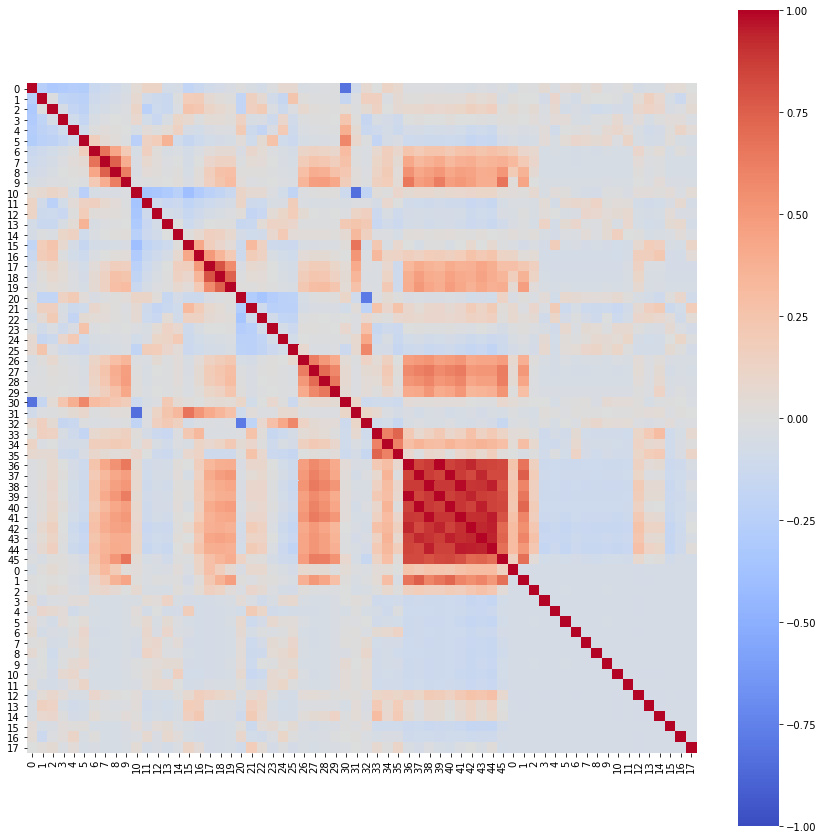

In [5]:
# plot feature correlation of cleaned data
heatmap(df_clean)

In [6]:
from sklearn.model_selection import train_test_split

# split data; note, we are using the data that still contains outliers. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

### 2. Hyperparameter optimization with grid search

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# model framework for gridsearch
def create_model(p=0, nodes=32, activation='relu',learning_rate=0.01): 
    # p is the dropout ratio ex: 0.2 to drop out 20% of layers
    # activation is the activation function for the input and hidden layers ex: 'relu'
    # nodes is the number of nodes in each of the 3 hidden layers

    # create model
    model = Sequential()
    # create input layer
    model.add(Dense(X.shape[1], input_dim=X.shape[1], activation=activation)) # input layer with number of nodes = number of attributes
    # create hidden layers
    model.add(Dense(nodes, activation=activation)) # create hidden layer
    model.add(Dropout(p)) # apply dropout layer with dropout probability p
    model.add(Dense(nodes, activation=activation)) # create hidden layer
    model.add(Dropout(p)) # apply dropout layer with dropout probability p
    model.add(Dense(nodes, activation=activation)) # create hidden layer
    model.add(Dropout(p)) # apply dropout layer with dropout probability p
    # create output layer and compile
    model.add(Dense(Y.shape[1], activation = 'softmax')) # number of nodes = number of output classes
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name="precision"),keras.metrics.Recall(name="recall")])
    
    return model

The code below is commented out because it takes a long time to run

In [52]:
from sklearn.model_selection import GridSearchCV

# define gridsearch
model = KerasClassifier(build_fn=create_model, epochs=500, batch_size=1000, verbose=0)
p = [0.025, 0.05, 0.1]
nodes=[128, 256, 512]
activation = ['relu']
learning_rate = [0.001,0.0001,0.00001]
param_grid = dict(p = p, nodes = nodes, activation = activation, learning_rate=learning_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1) # use 3 fold cross val, and all processors

# perform gridsearch
grid_result = grid.fit(X_train, Y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 111.7min finished


In [53]:
# find best hyperparameter values
grid.best_params_

{'activation': 'relu', 'learning_rate': 0.001, 'nodes': 512, 'p': 0.1}

In [54]:
# print grid search results
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
parameters = grid.cv_results_['params']
for mean, std, params in zip(means, stds, parameters):
        print("%f (+/-%f) for %r"
              % (mean, std * 2, params))
print("Best parameters:",grid.best_params_)

0.766083 (+/-0.010452) for {'activation': 'relu', 'learning_rate': 0.001, 'nodes': 128, 'p': 0.025}
0.774565 (+/-0.009598) for {'activation': 'relu', 'learning_rate': 0.001, 'nodes': 128, 'p': 0.05}
0.768806 (+/-0.015509) for {'activation': 'relu', 'learning_rate': 0.001, 'nodes': 128, 'p': 0.1}
0.803294 (+/-0.013205) for {'activation': 'relu', 'learning_rate': 0.001, 'nodes': 256, 'p': 0.025}
0.807504 (+/-0.010067) for {'activation': 'relu', 'learning_rate': 0.001, 'nodes': 256, 'p': 0.05}
0.811281 (+/-0.002386) for {'activation': 'relu', 'learning_rate': 0.001, 'nodes': 256, 'p': 0.1}
0.814067 (+/-0.001070) for {'activation': 'relu', 'learning_rate': 0.001, 'nodes': 512, 'p': 0.025}
0.819330 (+/-0.003833) for {'activation': 'relu', 'learning_rate': 0.001, 'nodes': 512, 'p': 0.05}
0.830970 (+/-0.009522) for {'activation': 'relu', 'learning_rate': 0.001, 'nodes': 512, 'p': 0.1}
0.571234 (+/-0.009901) for {'activation': 'relu', 'learning_rate': 0.0001, 'nodes': 128, 'p': 0.025}
0.562443

### 3. Model training

In [8]:
# model framework for optimized model
def create_optimized_model(p=0.1, nodes=512, learning_rate=0.001, activation='relu'): 
    # p is the dropout ratio ex: 0.2 to drop out 20% of layers
    # activation is the activation function for the input and hidden layers ex: 'relu'
    # nodes is the number of nodes in each of the 3 hidden layers

    # create model
    model = Sequential()
    # create input layer
    model.add(Dense(X.shape[1], input_dim=X.shape[1], activation=activation)) # input layer with number of nodes = number of attributes
    # create hidden layers
    model.add(Dense(nodes, activation=activation)) # create hidden layer
    model.add(Dropout(p)) # apply dropout layer with dropout probability p
    model.add(Dense(nodes, activation=activation)) # create hidden layer
    model.add(Dropout(p)) # apply dropout layer with dropout probability p
    model.add(Dense(nodes, activation=activation)) # create hidden layer
    model.add(Dropout(p)) # apply dropout layer with dropout probability p
    # create output layer and compile
    model.add(Dense(Y.shape[1], activation = 'softmax')) # number of nodes = number of output classes
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name="precision"),keras.metrics.Recall(name="recall")])
    
    return model

In [10]:
# train model with training data
import time
start_time = time.time()
testmodel = create_optimized_model() 
testmodel.fit(X_train, Y_train, epochs = 750, batch_size = 500, verbose=0)
testmodel.evaluate(X_test, Y_test)
print("%s seconds" % (time.time() - start_time))

217/217 [==============================] - 1s 2ms/step - loss: 1.2923 - accuracy: 0.8540 - precision: 0.8587 - recall: 0.8518
459.05531191825867 seconds


Note, our overall accuracy, precision, and recall are reported above.

### 4. Model evaluation

In [16]:
import pandas as pd

# evaluate model by class
classes = {"A":"Walking","B":"Jogging","C":"Stairs","D":"Sitting",
           "E":"Standing","F":"Typing","G":"Brushing teeth","H":"Eating soup",
           "I":"Eating chips","J":"Eating pasta","K":"Drinking from a cup",
           "L":"Eating sandwich","M":"Kicking (soccer ball)","O":"Playing catch (with tennis ball)",
           "P":"Dribbling (basketball)", "Q":"Writing","R":"Clapping","S":"Folding clothes"}
activityeval = {}
for i in encoder.classes_: # iterate through classes
    j = encoder.transform([i])
    idx = Y_test[j[0]] # create reference array to only choose samples from the i'th (aka j'th) class
    Y1 = Y_test[idx==1]
    X1 = X_test[idx==1]
    evaluation = testmodel.evaluate(X1, Y1, verbose=0)
    activityeval[classes[i]] = evaluation
activityeval_df = pd.DataFrame(activityeval, index=['loss','accuracy','precision','recall'])
activityeval_df

,Walking,Jogging,Stairs,Sitting,Standing,Typing,Brushing teeth,Eating soup,Eating chips,Eating pasta,Drinking from a cup,Eating sandwich,Kicking (soccer ball),Playing catch (with tennis ball),Dribbling (basketball),Writing,Clapping,Folding clothes
loss,0.601391,0.375995,1.197000,1.697852,1.175902,1.482525,1.147294,1.551101,1.329541,1.743391,1.844458,1.766275,0.639116,1.637222,1.057213,1.770847,1.178185,1.297929
accuracy,0.932615,0.958435,0.912568,0.827586,0.879487,0.852507,0.869081,0.792614,0.796875,0.750000,0.764706,0.797333,0.920455,0.808126,0.894118,0.834225,0.876574,0.873762
precision,0.932615,0.960591,0.920110,0.833780,0.886305,0.855030,0.870786,0.797688,0.805263,0.751462,0.772973,0.801075,0.920273,0.815490,0.895735,0.842818,0.883249,0.880000
recall,0.932615,0.953545,0.912568,0.824934,0.879487,0.852507,0.863510,0.784091,0.796875,0.747093,0.764706,0.794667,0.918182,0.808126,0.889412,0.831551,0.876574,0.871287


Text(0, 0.5, 'activity')

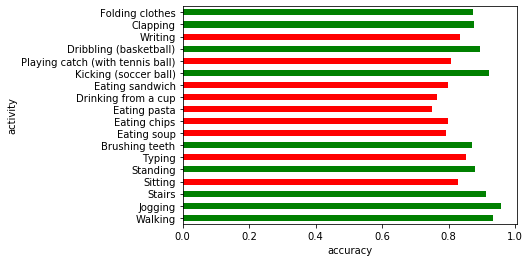

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# plot accuracies by class
accuracies = activityeval_df.iloc[1:2].T
colors = []
for i in np.array(accuracies):
    if i > 0.86: # if above average accuracy
        colors.append('green')
    else:
        colors.append('red')
ax = accuracies.plot.barh(y="accuracy",color=colors,legend=False)
ax.set_xlabel("accuracy")
ax.set_ylabel("activity")

Now that we have proven our model is accurate, we could train a model with all of the data for the best prediction accuracy.